# Introduction

This project is to create a Generative Adversarial Network to generate fake Monet paintings from ordinary photographs. The data for this project comes from this Kaggle competition:

https://www.kaggle.com/competitions/gan-getting-started

A github repo containing the code for this project can be found here:

https://github.com/billingsmoore/Monet-Forging

To create this project I drew on the tutorial provided (and recommended) by the Kaggle competition. This tutorial inspired much of the implementation of the training step function. To create the architecture I drew on the Keras tutorial for Deep Convolutional GAN's.



# Setup

In [1]:
import tensorflow as tf
import tensorrt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

#from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_syster(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

print(tf.__version__)

2023-08-02 22:15:52.181440: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-02 22:15:53.101989: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/j/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Number of replicas: 1
2.13.0


# Load in Data

In [2]:
#GCS_PATH = KaggleDatasets().get_gcs_path()

In [3]:
MONET_FILENAMES = tf.io.gfile.glob(str('gan-getting-started/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob('gan-getting-started/photo_tfrec/*.tfrec')
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [4]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [5]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [6]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

2023-08-02 22:15:55.125076: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-02 22:15:55.177366: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-02 22:15:55.178127: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Generator

The generator creates fake Monets from the photo images. This model is essentially a Convolutional AutoEncoder. Images are first downsampled and then re-upsampled to their original size.

In [7]:
def Generator():
    generator = keras.Sequential([
        keras.Input(shape=(256,256,3)),
        
        layers.Conv2D(512, 4, 2, "same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(256, 4, 2, "same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, 4, 2, "same"),
        layers.LeakyReLU(alpha=0.2),

        layers.Conv2DTranspose(128, 4, 2, "same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, 4, 2, "same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, 4, 2, "same"),
        layers.LeakyReLU(alpha=0.2),
    
        layers.Conv2D(3, 5, padding="same", activation="tanh")
    ])
    
    return generator

# Build the Discriminator

The discriminator takes in an image and classifies it as a real or fake Monet. The discriminator is very close to a typical binary classification neural network.

In [8]:
def Discriminator():
    discriminator = keras.Sequential([
        keras.Input(shape=(256,256,3)),
        layers.Conv2D(64, 4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, 4, 2, "same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, 4, 2, "same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid")
    ])
    
    return discriminator

In [9]:
with strategy.scope():
    monet_generator = Generator()
    photo_generator = Generator()
    
    monet_discriminator = Discriminator()
    photo_discriminator = Discriminator()

# Build the Model

In [10]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.optimizer = optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_monet = self.p_gen(fake_monet, training=True)
            
            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_photo = self.m_gen(fake_photo, training=True)
            
            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)
            
            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)
            
            #discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)
            
            # evaluate generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)
            
            # evaluate total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)
                
            # evaluate total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)
                
            # evaluate discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)
            
            # calculate gradient for generator and discriminator
            monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
            photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)
            monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
            photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)
            
            # apply the gradients to the optimizer
            self.optimizer.apply_gradients(zip(monet_generator_gradients,self.m_gen.trainable_variables))
            self.optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))
            self.optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
            self.optimizer.apply_gradients(zip(photo_discriminator_gradients,self.p_disc.trainable_variables))
            
            return {
                "monet_gen_loss": total_monet_gen_loss,
                "photo_gen_loss": total_photo_gen_loss,
                "monet_disc_loss": monet_disc_loss,
                "photo_disc_loss": photo_disc_loss
            }

# Define the Loss Function

The loss function compares the results to an ideal result of all 1's. The discriminator loss ouputs the average of the real and generated loss.

In [11]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        
        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        
        total_disc_loss = real_loss + generated_loss
        
        return total_disc_loss * 0.5

The generator loss is just Binary Crossentropy compared to our ideal result of all 1's.

In [12]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [13]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
        
        return LAMBDA * loss1

The identity loss compares the image with its generator. Given a photo, we want it to generate the same image. Identity loss compares the input image to the output image.

In [14]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

# Train the Model

In [15]:
with strategy.scope():
    cycle_gan_model = CycleGan(monet_generator,
                              photo_generator,
                              monet_discriminator,
                              photo_discriminator)
    cycle_gan_model.compile(
        optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5),
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [16]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=5
)

Epoch 1/5


/home/j/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


2023-08-02 22:16:01.822472: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2023-08-02 22:16:01.945502: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2023-08-02 22:16:01.945532: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2023-08-02 22:16:01.945639: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-08-02 22:16:03.956230: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-02 22:16:04.320179: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran 

300/300 [==============================] - 66s 186ms/step - monet_gen_loss: 12.5828 - photo_gen_loss: 12.7758 - monet_disc_loss: 0.5981 - photo_disc_loss: 0.6305
Epoch 2/5
300/300 [==============================] - 56s 186ms/step - monet_gen_loss: 12.6133 - photo_gen_loss: 12.5566 - monet_disc_loss: 0.5689 - photo_disc_loss: 0.5497
Epoch 3/5
300/300 [==============================] - 56s 185ms/step - monet_gen_loss: 12.1804 - photo_gen_loss: 12.4507 - monet_disc_loss: 0.5731 - photo_disc_loss: 0.4911
Epoch 4/5
300/300 [==============================] - 56s 186ms/step - monet_gen_loss: 12.2427 - photo_gen_loss: 12.4819 - monet_disc_loss: 0.5690 - photo_disc_loss: 0.5125
Epoch 5/5
300/300 [==============================] - 56s 186ms/step - monet_gen_loss: 12.0912 - photo_gen_loss: 12.4588 - monet_disc_loss: 0.5193 - photo_disc_loss: 0.4557


# Visualize Results

<function matplotlib.pyplot.show(close=None, block=None)>

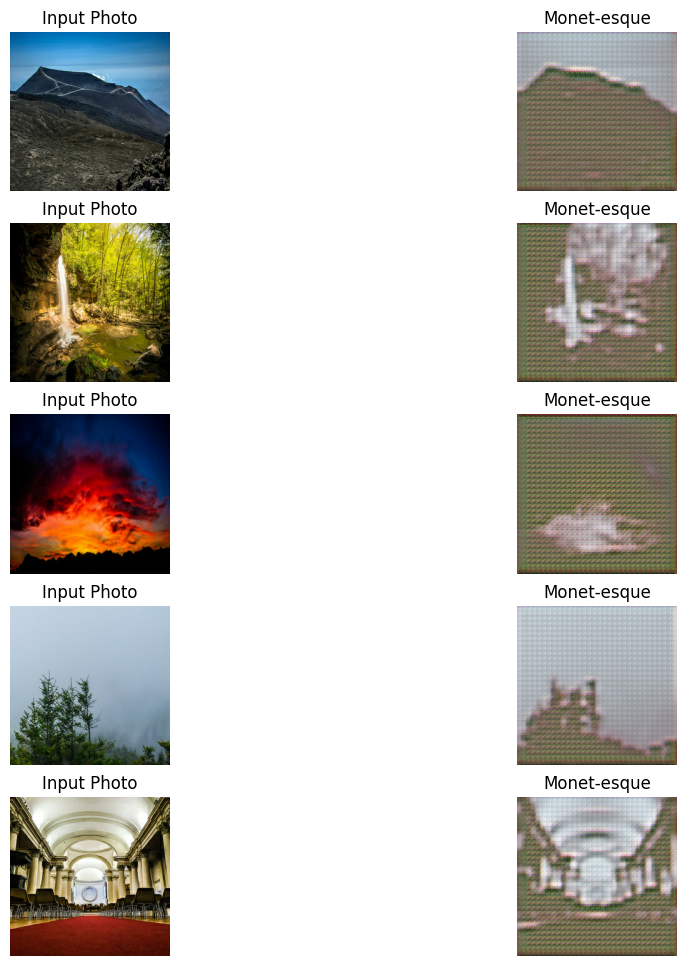

In [21]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    
    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show

# Create Submission File

In [18]:
""" import PIL
! mkdir ../images """

' import PIL\n! mkdir ../images '

In [19]:
""" i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.absuint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1 """

' i = 1\nfor img in photo_ds:\n    prediction = monet_generator(img, training=False)[0].numpy()\n    prediction = (prediction * 127.5 + 127.5).astype(np.absuint8)\n    im = PIL.Image.fromarray(prediction)\n    im.save("../images/" + str(i) + ".jpg")\n    i += 1 '

In [20]:
""" import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images") """

' import shutil\nshutil.make_archive("/kaggle/working/images", \'zip\', "/kaggle/images") '